# MOM6 input files for layered stacked shallow water

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# First define grid
# The numbers are the same as in Constantinou and Hogg, 2019 GRL
NI, NJ, NK = 800, 400, 2 # number of points in zonal, meridional and vertical levels
LENLON, LENLAT = 3200., 1600. # in km 
MAXIMUM_DEPTH = 4000.   # in m 
WESTLON, SOUTHLAT = 0.0, 0.0

X = np.linspace(WESTLON + LENLON/(NI*2), WESTLON + LENLON - LENLON/(2*NI), NI)
Y = np.linspace(SOUTHLAT + LENLAT/(NJ*2), SOUTHLAT + LENLAT - LENLAT/(NJ*2), NJ) - LENLAT/2.

Xm, Ym = np.meshgrid(X,Y)

In [13]:
def flat_bottom():
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    return D

def Navid_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    #ridge = np.exp(-((Xm - LENLON/6)/sigma)**2) + np.exp(-((Xm - 2*LENLON/6)/sigma)**2) \
    #+ np.exp(-((Xm - 3*LENLON/6)/sigma)**2) + np.exp(-((Xm - 4*LENLON/6)/sigma)**2) \
    #+ np.exp(-((Xm - 5*LENLON/6)/sigma)**2)
    #ridge = ridge*H0/np.max(ridge)
    
    ridge = np.exp(-((Xm - 400.)/sigma)**2) + np.exp(-((Xm - 1000.)/sigma)**2) \
    + np.exp(-((Xm - 1600.)/sigma)**2) + np.exp(-((Xm - 2200.)/sigma)**2) \
    + np.exp(-((Xm - 2800.)/sigma)**2)
    ridge = ridge*H0/np.max(ridge)
    
    D = D - ridge
    return D

def guassian_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.exp(-((Xm - LENLON/2)/sigma)**2)
    ridge = ridge - np.min(ridge)
    ridge = ridge*H0/np.max(ridge)
    D = D - ridge
    return D

def sin_ridge_bottom(H0, n):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.sin(2*np.pi*n*Xm/LENLON - np.pi/2.)
    ridge = (H0)*ridge
    ridge[ridge < 0.] = 0. # negative values are removed
    D = D - ridge
    return D

def zero_velocity():
    u = np.zeros((NK,NJ,NI))
    v = np.zeros((NK,NJ,NI))
    return u,v

def wind_stress(tau_0):
    taux = tau_0*np.sin(np.pi*Ym/LENLAT)**2
    tauy = np.zeros((NJ,NI))
    return taux, tauy

def wind_stress_fix_width(tau_0,jet_width):
    no_jet = 1. - jet_width
    #taux = tau_0*np.sin(np.pi*(Ym - no_jet*LENLAT/2.)/(jet_width*LENLAT))**2
    taux = tau_0*np.cos(np.pi*Ym/(jet_width*LENLAT))**2
    taux[:int(np.round(no_jet*NJ/2.)),:] = 0.
    taux[int(np.round((jet_width + no_jet/2.)*NJ)):,:] = 0.
    tauy = np.zeros((NJ,NI))
    return taux, tauy

def wind_stress_fix_grad_fix_area(tau_0, base_tau, base_jet_width):
    tau_g = np.sqrt(base_tau*tau_0)
    amp = tau_g/base_tau
    jet_width = base_jet_width*amp 
    no_jet = 1. - jet_width
    taux = tau_g*np.cos(np.pi*Ym/(jet_width*LENLAT))**2
    taux[:int(np.round(no_jet*NJ/2.)),:] = 0.
    taux[int(np.round((jet_width + no_jet/2.)*NJ)):,:] = 0.
    tauy = np.zeros((NJ,NI))
    return taux, tauy
    
def wind_stress_var_width(tau_0, base_tau, base_jet_width):
    amp = tau_0/base_tau
    jet_width = base_jet_width*amp 
    no_jet = 1. - jet_width
    taux = tau_0*np.cos(np.pi*Ym/(jet_width*LENLAT))**2
    taux[:int(np.round(no_jet*NJ/2.)),:] = 0.
    taux[int(np.round((jet_width + no_jet/2.)*NJ)):,:] = 0.
    tauy = np.zeros((NJ,NI))
    return taux, tauy

def wind_stress_Navid(tau_0):
    taux = tau_0*np.sin(np.pi*(Ym - 0*LENLAT/4.)/(3*LENLAT/4))**2
    taux[int(np.round(3*NJ/4)):,:] = 0.
    tauy = np.zeros((NJ,NI))
    return taux, tauy

# Returns an array h[k,j,i] representing the layer thickness of the k-th layer at (lat,lon) 
# and an array eta[k,j,i] with the heights of each interface.
# Note that h has NK values in the vertical while eta has NK+1 values.
# k = 0 is the surface layer, with increasing k descending down the layers.
# h[i,j,k] >= ANGSTROM, which is the minimum layer thickness.
# input : D[i,j], a two-dimensional array of the depth of the ocean.
def layer_thickness(eta0, depth):
    eta = np.zeros((NK+1,NJ,NI))
    h = np.zeros((NK,NJ,NI))
    
    eta[NK-1,:,:] = eta0[1]
    eta[NK,:,:] = - depth
    
    for k in range(0,NK):
        h[k,:,:] = eta[k,:,:] - eta[k+1,:,:]
        
    return h, eta

0.005333333333333333 [1027.35, 1027.9091020408162]


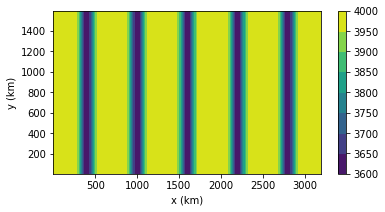

In [19]:
# Generate Topography
ridge_h0 = 400.
sigma = 165./2
n_ridge = 5

H1, H2 = (1000., 3000.)

#depth = guassian_ridge_bottom(ridge_h0, sigma)
#depth = sin_ridge_bottom(ridge_h0, n_ridge)
depth = Navid_ridge_bottom(ridge_h0,sigma)
eta0 = [0., -H1, -MAXIMUM_DEPTH]
h, eta = layer_thickness(eta0, depth)

# g_prime can be computed for a given rossby deformation radius value. This is used in the MOM_input file
# Or layer densities can supplied in MOM_input
Rd = 20000.
f = -10**-4
gp = Rd**2*MAXIMUM_DEPTH*f**2/(H1*H2)

rho_0 = 1027.35
rho_1 = gp*rho_0/9.8 + rho_0

density = [rho_0, rho_1]

print(gp, density)


fig = plt.figure(figsize=[6,3])
plt.contourf(X,Y,depth)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.colorbar()
#plt.plot(X, H1 + H2 - depth[0,:])
#plt.ylim([0, 4000.])

In [20]:
# Save topographic and thickness data to nc file
ds = xr.Dataset(
        data_vars={'depth': (('lat', 'lon'), depth),
                   'h': (('level', 'lat', 'lon'), h),
                   'eta': (('interface','lat', 'lon'), eta)},
    coords={'lat': Y, 'lon': X, 'depth_list': eta0, 'level': density})

ds.lat.attrs['units'] = 'km'
ds.lon.attrs['units'] = 'km'
ds.depth_list.attrs['units'] = 'm'
ds.level.attrs['units'] = 'kg m-3'
ds.depth.attrs['units'] = 'm'
ds.h.attrs['units'] = 'm'
ds.eta.attrs['units'] = 'm'

ds.lon.attrs['standard_name'] = 'Longitude'
ds.lat.attrs['standard_name'] = 'Latitude'
ds.depth_list.attrs['standard_name'] = 'Mean Interface Height'
ds.level.attrs['standard_name'] = 'Mean Layer Density'
ds.depth.attrs['standard_name'] = 'Total Depth'
ds.h.attrs['standard_name'] = 'Layer Depth'
ds.eta.attrs['standard_name'] = 'Interface Height'

file = 'topography.nc'
ds.to_netcdf(path=file)

In [22]:
ds

<xarray.Dataset>
Dimensions:     (depth_list: 3, interface: 3, lat: 400, level: 2, lon: 800)
Coordinates:
  * lat         (lat) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * lon         (lon) float64 2.0 6.0 10.0 14.0 ... 3.19e+03 3.194e+03 3.198e+03
  * depth_list  (depth_list) float64 0.0 -1e+03 -4e+03
  * level       (level) float64 1.027e+03 1.028e+03
Dimensions without coordinates: interface
Data variables:
    depth       (lat, lon) float64 4e+03 4e+03 4e+03 4e+03 ... 4e+03 4e+03 4e+03
    h           (level, lat, lon) float64 1e+03 1e+03 1e+03 ... 3e+03 3e+03
    eta         (interface, lat, lon) float64 0.0 0.0 0.0 ... -4e+03 -4e+03

$\large \text{Wind Stress Profile}$

We assume that the zonal wind stress is maximum at the center of the domain and follows the following functional form
$$\tau = \tau_o\cos^2\left[\frac{\pi y}{\delta L_y}\right], -\delta L_y/2 < y<\delta L_y/2$$

Here, $\delta$, which has value between 0 and 1, is the relative width of the wind stress profile. In the first set of experiments, only $\tau_o$ is varied. In the second set of experiments, $\delta$ is also varied in response to changes in $\tau_o$ to keep the maximum magnitude of $\frac{\partial \tau}{\partial y}$ across also experiements and $\int_{\frac{-\delta L_y}{2}}^{\frac{\delta L_y}{2}} \tau dy = \frac{\tau_o\delta L_y}{2}$ is the same as in correponding experiment for which only $\tau_o$ was changed. 

Let's assume that $\tau_b$ and $\delta_b$ are base values, $\tau_f$ and $\delta_b$ are new values in the experiment with fixed width and $\tau_g$ and $\delta_g$ are new values in the experiment with fixed meridional gradient. It is trivial to show that, in order to conserve maximum value in gradient, 

$$\frac{\tau_g}{\delta_g} = \frac{\tau_b}{\delta_b}$$
For the area to be the same,
$$\tau_g\delta_g = \tau_f\delta_b$$
From these relations, we have
$$\tau_g = \sqrt{\tau_b\tau_f}, \delta_g = \delta_b\frac{\tau_f}{\tau_b}$$

Fix =  240.0  Var =  239.99999725040388


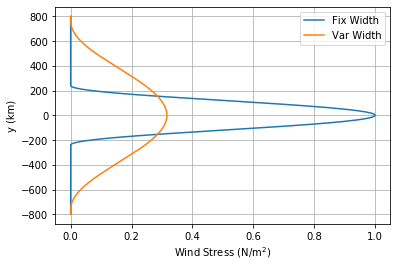

In [26]:
tau_b = 0.1 # base value
jet_width = 0.3 # base value
tau_f = 1.

taux1, tauy = wind_stress_fix_width(tau_f, jet_width)
taux2, tauy = wind_stress_fix_grad_fix_area(tau_f, tau_b, jet_width)
print('Fix = ', np.sum(taux1[:,0])*LENLAT/NJ, ' Var = ', np.sum(taux2[:,0])*LENLAT/NJ)

plt.plot(taux1[:,0],Y, label='Fix Width')
plt.plot(taux2[:,0],Y, label='Var Width')
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress (N/m$^2$)')
plt.legend()
plt.grid()

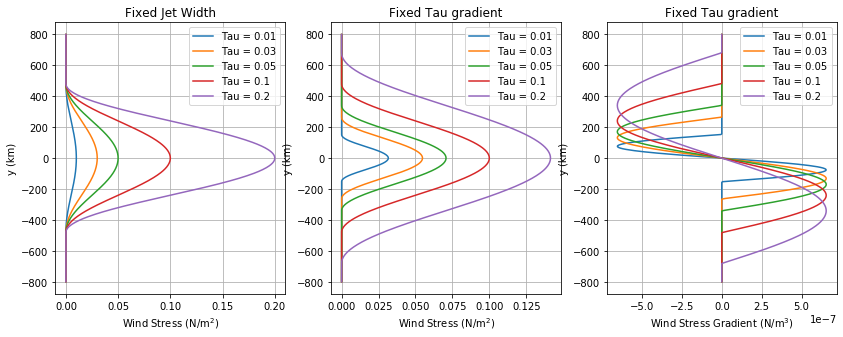

In [23]:
# Wind Stress
tau_0 = 0.1

mag = np.array([0.01, 0.03, 0.05, 0.1, 0.2])

jet_width = 0.6

fig = plt.figure(figsize=[14,5])

plt.subplot(1,3,1)

for i in range(0,len(mag)):
    taux, tauy = wind_stress_fix_width(mag[i], jet_width)
    plt.plot(taux[:,0],Y, label='Tau = '+str(mag[i]))
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress (N/m$^2$)')
plt.title('Fixed Jet Width')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
for i in range(0,len(mag)):
    taux, tauy = wind_stress_fix_grad_fix_area(mag[i], tau_0, jet_width)
    plt.plot(taux[:,0],Y, label='Tau = '+str(mag[i]))
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress (N/m$^2$)')
plt.title('Fixed Tau gradient')
plt.legend()
plt.grid()


plt.subplot(1,3,3)
for i in range(0,len(mag)):
    taux, tauy = wind_stress_fix_grad_fix_area(mag[i], tau_0, jet_width)
    plt.plot(np.diff(taux[:,0])/(LENLAT*1000./(NJ*2)), 0.5*(Y[0:-1]+Y[1:]), label='Tau = '+str(mag[i]))
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress Gradient (N/m$^3$)')
plt.title('Fixed Tau gradient')
plt.legend()
plt.grid()

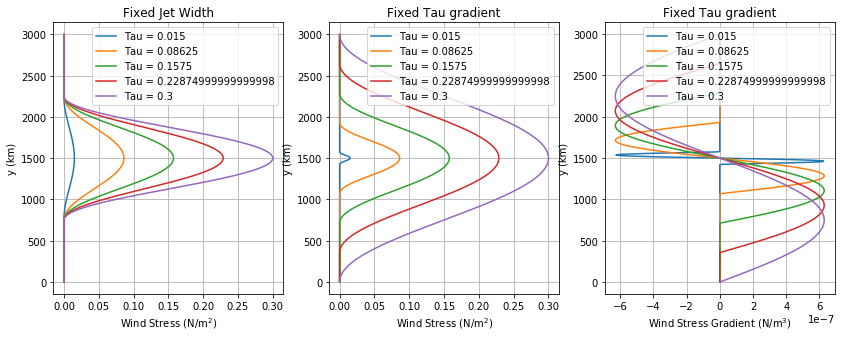

In [19]:
# Wind Stress
tau_0 = 0.1

mag = np.linspace(0.1,2.0,5)

jet_width = 0.5

fig = plt.figure(figsize=[14,5])

plt.subplot(1,3,1)

for i in range(0,len(mag)):
    taux, tauy = wind_stress_fix_width(tau_0*mag[i], jet_width)
    plt.plot(taux[:,0],Y, label='Tau = '+str(tau_0*mag[i]))
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress (N/m$^2$)')
plt.title('Fixed Jet Width')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
for i in range(0,len(mag)):
    taux, tauy = wind_stress_var_width(tau_0*mag[i], tau_0, jet_width)
    plt.plot(taux[:,0],Y, label='Tau = '+str(tau_0*mag[i]))
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress (N/m$^2$)')
plt.title('Fixed Tau gradient')
plt.legend()
plt.grid()


plt.subplot(1,3,3)
for i in range(0,len(mag)):
    taux, tauy = wind_stress_var_width(tau_0*mag[i], tau_0, jet_width)
    plt.plot(np.diff(taux[:,0])/(LENLAT*1000./(NJ*2)), 0.5*(Y[0:-1]+Y[1:]), label='Tau = '+str(tau_0*mag[i]))
plt.ylabel('y (km)')    
plt.xlabel('Wind Stress Gradient (N/m$^3$)')
plt.title('Fixed Tau gradient')
plt.legend()
plt.grid()

In [8]:
# Save data to nc file
ds = xr.Dataset(
        data_vars={'taux':    (('lat', 'lon'), taux),
                   'tauy': (('lat', 'lon'), tauy)},
    coords={'lat': Y, 'lon': X})

ds.lat.attrs['units'] = 'km'
ds.lon.attrs['units'] = 'km'
ds.taux.attrs['units'] = 'N m-2'
ds.tauy.attrs['units'] = 'N m-2'

ds.lon.attrs['standard_name'] = 'Longitude'
ds.lat.attrs['standard_name'] = 'Latitude'
ds.taux.attrs['standard_name'] = 'Zonal Wind Stress'
ds.tauy.attrs['standard_name'] = 'Meridional Wind Stress'

#file = str(round(ridge_h0)) + '_n_' + str(round(n_ridge)) + '.nc'
file = 'wind_stress.nc'
ds.to_netcdf(path=file)